In [1]:
import pystac
import pystac_client
import boto3
import icechunk
import zarr
import xarray as xr
import os
import numpy as np
import shapely
from shapely import wkt
import warnings
from datetime import datetime, timezone, timedelta
from obstore.store import S3Store
from virtualizarr import open_virtual_dataset
from virtualizarr.registry import ObjectStoreRegistry
from virtual_tiff import VirtualTIFF
from obstore.auth.boto3 import Boto3CredentialProvider
from rasterio.warp import transform_bounds
from zarr.dtype import VariableLengthUTF8
from zarr_datafusion_search import ZarrTable
from datafusion import SessionContext
import pyproj
import xproj
import rasterix
import logging
import morecantile
from shapely.ops import transform
from pyproj import Transformer

In [2]:
warnings.filterwarnings("ignore")
xr.set_options(display_expand_indexes=True)

In [3]:
# Connect to Earth Search STAC API
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

california_bbox = [-124.4096, 32.5343, -114.1312, 42.0095]

search = catalog.search(
    collections=["landsat-c2-l2"],  # Landsat Collection 2 Level-2
    bbox=california_bbox,
    datetime="2025-10-01/2025-10-10",
    max_items=10
)

items = list(search.items())

In [4]:
item = items[0]
item

<Item id=LC09_L2SP_045034_20251009_02_T2>

In [5]:
scheme = "s3://"
bucket = "usgs-landsat"
region = "us-west-2"

In [6]:
profile = "impactnew"
os.environ["AWS_PROFILE"] = profile

In [7]:
session = boto3.Session()
object_store = S3Store(
    bucket=bucket,
    region=region,
    request_payer=True,
    credential_provider=Boto3CredentialProvider(session=session),
)
registry = ObjectStoreRegistry({f"{scheme}{bucket}": object_store})

In [8]:
location = "data/icechunk"
storage = icechunk.local_filesystem_storage(location)

config = icechunk.RepositoryConfig.default()
s3_chunk_store = icechunk.s3_store(
    region=region,
    requester_pays=True,
)
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(f"{scheme}{bucket}/", s3_chunk_store)
)
credentials = icechunk.containers_credentials(
    {f"{scheme}{bucket}/": icechunk.s3_credentials(from_env=True)}
)
repo = icechunk.Repository.open_or_create(
    storage=storage, config=config, authorize_virtual_chunk_access=credentials
)
session = repo.writable_session("main")

  2025-11-12T17:12:55.216952Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



In [11]:
overviews = 7

In [12]:
def write_item_data(item: pystac.Item):
    overviews = 7
    #assets = {asset_key: asset for asset_key, asset in item.assets.items() if asset.media_type == "image/tiff; application=geotiff; profile=cloud-optimized"}
    for key in ["red"]:
        asset = item.assets[key]
        for overview in range(overviews):
            group = f"{item.id}/{key}/multiscales/{overview}"
            ds = open_virtual_dataset(
                url=asset.href,
                registry=registry,
                parser=VirtualTIFF(ifd=overview)
            )
            ds.vz.to_icechunk(
                store=session.store,
                group=group,
            )
        

In [13]:
def write_metadata_schema():
    root = zarr.open_group(session.store, mode="w", zarr_format=3)
    meta = root.create_group("meta")
    meta.create_array(
        "date",
        shape=(0,),
        dtype="datetime64[ms]",
    )
    meta.create_array(
        "bbox",
        shape=(0,),
        dtype=VariableLengthUTF8(),
    )
    meta.create_array(
        "group_path",
        shape=(0,),
        dtype=VariableLengthUTF8(),
    )

In [14]:
def write_item_metadata(item: pystac.Item):
    dt = zarr.open(
        store=session.store,
        path="/meta/date",
        mode="a"
    )
    dt.append(np.array([item.datetime], dtype="datetime64[ms]"))

    bbox_wkt = shapely.to_wkt(shapely.box(*item.bbox))
    bbox = zarr.open(
        store=session.store,
        path="/meta/bbox",
        mode="a"
    )
    bbox.append(np.array([bbox_wkt]))

    group_path = zarr.open(
        store=session.store,
        path="/meta/group_path",
        mode="a"
    )
    group_path.append(np.array([f"/{item.id}"])) 

In [15]:
def generate_multiscales(overviews: int):
    layout = list()
    for overview in range(overviews):
        if overview == 0:
            config = {
                "group": str(overview)
            }
        else:
            factor = 2
            scale = float(factor * overview)
            config = {
                "group": str(overview),
                "from_group": str(overview - 1),
                "factors": [factor, factor],
                "scale": [scale, scale],
                "translation": [0.0, 0.0],
                "resampling_method": "average"
            }
        layout.append(config)
                
    multiscales_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/multiscales/refs/tags/v0.1.0/schema.json",
        "name": "Multiscales Attribute Extension",
        "description": "Geospatial power-of-2 pyramid composed with geo:proj for coordinate reference system",
        "spec": "https://github.com/zarr-experimental/multiscales/blob/v0.1.0/README.md",
        "configuration": {
            "version": "0.1.0",
            "layout": layout,
            "resampling_method": "average"
        }
    }
    return multiscales_extension

In [16]:
def generate_geoproj(item: pystac.Item):
    projected_bbox = transform_bounds(
        "EPSG:4326",
        item.properties["proj:code"],
        *item.bbox
    )
    geo_proj_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json",
        "name": "geo:proj",
        "description": "Coordinate reference system information for geospatial data",
        "spec": "https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md",
        "configuration": {
            "code": item.properties["proj:code"],
            "spatial_dimensions": ["y", "x"],
            "transform": ["proj:transform"],
            "bbox": projected_bbox
        }
    }
    return geo_proj_extension

In [17]:
def write_item_data(item: pystac.Item, overviews: int):
    #assets = {asset_key: asset for asset_key, asset in item.assets.items() if asset.media_type == "image/tiff; application=geotiff; profile=cloud-optimized"}
    for key in ["red"]:
        asset = item.assets[key]
        for overview in range(overviews):
            group = f"{item.id}/{key}/multiscales/{overview}"
            ds = open_virtual_dataset(
                url=asset.href,
                registry=registry,
                parser=VirtualTIFF(ifd=overview)
            )
            ds.vz.to_icechunk(
                store=session.store,
                group=group,
            )        

In [18]:
def write_item_conventions(item: pystac.Item, overviews: int):
    item_group = zarr.open_group(session.store, path=f"/{item.id}", zarr_format=3)
    multiscales_convention = generate_multiscales(overviews)
    geo_proj_convention = generate_geoproj(item)
    item_group.attrs["d35379db-88df-4056-af3a-620245f8e347"] = multiscales_convention
    item_group.attrs["f17cb550-5864-4468-aeb7-f3180cfb622f"] = geo_proj_convention

In [19]:
write_metadata_schema()
write_item_metadata(item=items[0])
write_item_data(item=items[0], overviews=overviews)
write_item_conventions(item=items[0], overviews=overviews)

In [20]:
session.commit("First")

'RTVJS1RR95N1QM063WJ0'

In [21]:
store = zarr.open(session.store)
store.tree()

/
├── LC09_L2SP_045034_20251009_02_T2
│   └── red
│       └── multiscales
│           ├── 0
│           │   └── 0 (7871, 7751) uint16
│           ├── 1
│           │   └── 1 (3936, 3876) uint16
│           ├── 2
│           │   └── 2 (1968, 1938) uint16
│           ├── 3
│           │   └── 3 (984, 969) uint16
│           ├── 4
│           │   └── 4 (492, 485) uint16
│           ├── 5
│           │   └── 5 (246, 243) uint16
│           └── 6
│               └── 6 (123, 122) uint16
└── meta
    ├── bbox (1,) StringDType()
    ├── date (1,) datetime64
    └── group_path (1,) StringDType()

In [22]:
zarr_table = await ZarrTable.from_icechunk(session=session, group_path="/meta")
ctx = SessionContext()
ctx.register_table_provider("icechunk_data", zarr_table)
sql = "SELECT * FROM icechunk_data WHERE date < CAST('2025-10-10' AS DATE);"
df = ctx.sql(sql)
df.show()

DataFrame()
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+
| bbox                                                                                                                          | date                    | group_path                       |
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+
| POLYGON ((-122.359698 36.393317, -122.359698 38.532961, -125.023673 38.532961, -125.023673 36.393317, -122.359698 36.393317)) | 2025-10-09T18:52:36.386 | /LC09_L2SP_045034_20251009_02_T2 |
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+


[src/table.rs:41:9] "Created icechunk session from msgpack serialization" = "Created icechunk session from msgpack serialization"
[src/table.rs:42:9] icechunk_session.config() = RepositoryConfig {
    inline_chunk_threshold_bytes: None,
    get_partial_values_concurrency: None,
    compression: None,
    max_concurrent_requests: None,
    caching: None,
    storage: None,
    virtual_chunk_containers: Some(
        {
            "s3://usgs-landsat/": VirtualChunkContainer {
                name: None,
                url_prefix: "s3://usgs-landsat/",
                store: S3(
                    S3Options {
                        region: Some(
                            "us-west-2",
                        ),
                        endpoint_url: None,
                        anonymous: false,
                        allow_http: false,
                        force_path_style: false,
                        network_stream_timeout_seconds: Some(
                            60,
      

In [23]:
first_row = df.to_arrow_table().to_pylist()[0]
item_group = zarr.open_group(session.store, path=first_row["group_path"], mode="r")
item_group_attrs = dict(item_group.attrs)

In [24]:
ds = xr.open_zarr(store=session.store, group=f"{first_row['group_path']}/red/multiscales/0")
ds

<xarray.Dataset> Size: 122MB
Dimensions:  (y: 7871, x: 7751)
Dimensions without coordinates: y, x
Data variables:
    0        (y, x) uint16 122MB ...

In [25]:
red_0 = ds["0"].proj.assign_crs(spatial_ref=item_group_attrs["f17cb550-5864-4468-aeb7-f3180cfb622f"]["configuration"]["code"])
red_0

<xarray.DataArray '0' (y: 7871, x: 7751)> Size: 122MB
[61008121 values with dtype=uint16]
Coordinates:
  * spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:32610)
Attributes:
    citation:                    WGS 84 / UTM zone 10N
    geog_angular_units:          9102
    geog_citation:               WGS 84
    model_type:                  1
    proj_linear_units:           9001
    projected_type:              32610
    raster_type:                 2
    model_pixel_scale:           [30.0, 30.0, 0.0]
    model_tiepoint:              [0.0, 0.0, 0.0, 323400.0, 4265400.0, 0.0]
    photometric_interpretation:  1
    gdal_no_data:                0

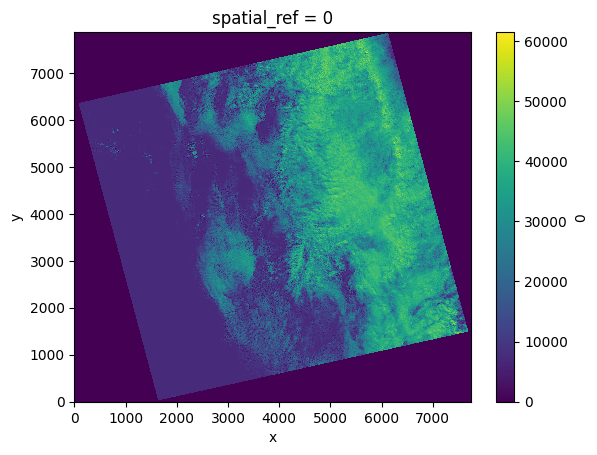

In [24]:
#os.environ["ICECHUNK_LOG"] = "trace"
#icechunk.set_logs_filter(None)
red_0.plot()

In [41]:
red_0 = red_0.pipe(rasterix.assign_index)

In [28]:
granule_bbox_geom = wkt.loads(first_row["bbox"])
granule_bbox = morecantile.commons.BoundingBox(*granule_bbox_geom.bounds)
tms = morecantile.tms.get("WebMercatorQuad")
tiles = list(tms.tiles(*granule_bbox, zooms=9))
tiles

[Tile(x=78, y=196, z=9),
 Tile(x=79, y=196, z=9),
 Tile(x=80, y=196, z=9),
 Tile(x=81, y=196, z=9),
 Tile(x=78, y=197, z=9),
 Tile(x=79, y=197, z=9),
 Tile(x=80, y=197, z=9),
 Tile(x=81, y=197, z=9),
 Tile(x=78, y=198, z=9),
 Tile(x=79, y=198, z=9),
 Tile(x=80, y=198, z=9),
 Tile(x=81, y=198, z=9),
 Tile(x=78, y=199, z=9),
 Tile(x=79, y=199, z=9),
 Tile(x=80, y=199, z=9),
 Tile(x=81, y=199, z=9),
 Tile(x=78, y=200, z=9),
 Tile(x=79, y=200, z=9),
 Tile(x=80, y=200, z=9),
 Tile(x=81, y=200, z=9)]

In [31]:
tile_bbox = tms.xy_bounds(tiles[3])
tile_bbox_geom = shapely.geometry.box(*tile_bbox)
utm_transformer = Transformer.from_crs(3857, item_group_attrs["f17cb550-5864-4468-aeb7-f3180cfb622f"]["configuration"]["code"], always_xy=True).transform
tile_bbox_utm = transform(utm_transformer, tile_bbox_geom)
tile_bbox_utm.bounds

(495899.786081677, 4236072.122409064, 557403.2885741958, 4297294.145613936)

In [37]:
left, bottom, right, top = tile_bbox_utm.bounds
red_0_tile = red_0.sel(x=slice(left, right), y=slice(top, bottom))
red_0_tile

<xarray.DataArray '0' (y: 0, x: 0)> Size: 0B
[0 values with dtype=uint16]
Coordinates:
  * y            (y) float64 0B 
  * x            (x) float64 0B 
  * spatial_ref  int64 8B 0
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:32610)
  ┌ x            RasterIndex (crs=EPSG:32610)
  └ y
Attributes:
    citation:                    WGS 84 / UTM zone 10N
    geog_angular_units:          9102
    geog_citation:               WGS 84
    model_type:                  1
    proj_linear_units:           9001
    projected_type:              32610
    raster_type:                 2
    model_pixel_scale:           [30.0, 30.0, 0.0]
    model_tiepoint:              [0.0, 0.0, 0.0, 323400.0, 4265400.0, 0.0]
    photometric_interpretation:  1
    gdal_no_data:                0

In [46]:
red_0.

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.748e+03, 7.749e+03,
       7.750e+03], shape=(7751,))